In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import scipy.optimize as opt
import numpy as np
import math

In [10]:
def generate_road(road_fn, n_samples, domain, eps=0):
    start_x, end_x = domain
    x = np.linspace(start_x, end_x, n_samples)
    return [(i - eps, road_fn(i)) for i in x]

road1_formula = lambda x: 2 * x + 0
road1 = generate_road(road1_formula, 500, (-30, 60))

road2_formula = lambda x: 10 * math.log(x + 30) - 30
road2 = generate_road(road2_formula, 500, (-20, 300), eps=.5)

road3_formula = lambda x: math.exp(x / 20) + 4
road3 = generate_road(road3_formula, 500, (-50, 100), eps=.5)

# plt.figure(figsize=(20, 5))
# plt.plot(*zip(*road3), color='gold', linestyle='--')

In [23]:
timeStep = 1

nSteps = 15
accelerationConstraint = 5
angularConstraint = 20

desiredVelocity = 10

costWeights = [6, 100, 4] # centerLineWeight, velocityWeight, headingWeight

# state: [[x1, y1, v1, h1], [x2, y2, v2, h2], ...]
# controls: [vx, vy, a, w]
def stateUpdateEqn(state, controls, timeStep):
    controls[0, 0] = state[2, 0] * np.cos(np.deg2rad(state[3, 0]))
    controls[1, 0] = state[2, 0] * np.sin(np.deg2rad(state[3, 0]))
    return state + timeStep * controls


def computeHeadingError(realHeading, desiredHeading):
    delta = desiredHeading - np.deg2rad(realHeading)
    return np.rad2deg(np.arctan2(np.sin(delta), np.cos(delta)))


def shortestDistanceToPolyline(pt, centerLinePts, discretization=5):

    distance = float('inf')
    tangentLine = None 
    for i in range(discretization, len(centerLinePts), discretization):
        ptA, ptB = centerLinePts[i - discretization], centerLinePts[i]

        centerLine = ptB - ptA
        midPt = (ptA + ptB) / 2
        projection = midPt
        
        # projection = (centerLine[0] * ptShift[0] + centerLine[1] * ptShift[1]) / torch.norm(centerLine, p=2)
        # projection = projection * centerLine + ptA

        rejection_dist = np.sqrt(np.square(pt[0] - projection[0]) + np.square(pt[1] - projection[1]))
        if rejection_dist < distance:
            tangentLine = centerLine
            distance = rejection_dist

    return distance, np.arctan2(tangentLine[1], tangentLine[0])


def loss_fn(initState, centerLine, costWeights, desiredStates, timeStep=1):

    centerLineWeight, velocityWeight, headingWeight = costWeights
    desiredVelocity = desiredStates

    def objective(params):
        cost = 0
        state = np.expand_dims(initState, axis=-1)
        for i in range(0, len(params), 2):
            control = np.expand_dims(np.concatenate(([0, 0], params[i:i+2])), axis=-1)
            state = stateUpdateEqn(state, control, timeStep)

            squeezeState = np.squeeze(state, axis=-1)
            cartesian, polar = squeezeState[:2], squeezeState[2:]
            x, y = cartesian
            velocity, heading = polar

            lateralError, roadHeading = shortestDistanceToPolyline(cartesian, centerLine)
            headingError = computeHeadingError(heading, roadHeading)
            velocityError = desiredVelocity - velocity
            
            # if verbose:
            #     print(f"state {j+1}:")
            #     print(f"x: {x}, y: {y}, velocity: {velocity}, heading: {heading}")
            #     print("distance error:", lateralError)
            #     print("velocity error:", velocityError)
            #     print("heading error:", headingError)

            cost += centerLineWeight * np.abs(lateralError) * (i + 1)
            cost += velocityWeight * np.abs(velocityError) * (i + 1)
            cost += headingWeight * np.abs(headingError) * (i + 1)
        
        return cost

    return objective


def formulate_guess(nSteps):
    return np.ones((nSteps * 2,))
    
    
init_guess = formulate_guess(nSteps)
bounds = [(-accelerationConstraint, accelerationConstraint), (-angularConstraint, angularConstraint)] * nSteps
centerLine = np.array(road3)

state0 = np.array([0, 0, 0, 0])

obj = loss_fn(state0, centerLine, costWeights, desiredVelocity, timeStep=timeStep)

result = opt.minimize(obj, init_guess, method='SLSQP', bounds=bounds, options={'eps': 1e-1, 'maxiter': 100})
result

     fun: 10164.669031767447
     jac: array([4024.88699105,  -18.2214873 , 3605.49200403,  -19.75718307,
       3432.04173801,  -14.64098658, 1805.22420814,  -12.47202818,
       1902.31032952,  -18.0078501 , 1281.96521117,  -38.88400904,
       1796.32064974,  -58.63796568,  806.31824693,  -70.35901912,
       1552.35145949,  -66.26504101, 2361.09134314,  -45.53624659,
       1324.54524525,  -22.88634746, 2939.40222814,  -17.93174692,
       2294.87178236,   -5.79101359, -136.03585515,   65.1594887 ,
         67.54481905,  -14.96767762])
 message: 'Optimization terminated successfully.'
    nfev: 1762
     nit: 48
    njev: 48
  status: 0
 success: True
       x: array([ 1.09757208e+00,  8.27450267e+00,  3.23662712e+00,  1.06822553e+01,
        2.35813895e+00, -1.64735961e+00,  3.02694548e+00, -3.34334385e+00,
        2.51544691e-01, -1.11728430e+00, -3.90189372e-01,  8.73339565e+00,
        3.86556566e-01,  4.76957674e+00, -9.84835638e-03,  8.00850462e+00,
       -5.20152595e-02,  7

x: 0, y: 0, velocity: 0, heading: 0
centerline error: 5.020628570136862
x: 0.0, y: 0.0, velocity: 1.0975720779956573, heading: 8.274502672059576
centerline error: 5.020628570136862
x: 1.0861462773421275, y: 0.15795800268281224, velocity: 4.334199196881321, heading: 18.956757964015008
centerline error: 4.947173727513677
x: 5.185275923547691, y: 1.565941959212622, velocity: 6.6923381506453925, heading: 17.309398351880542
centerline error: 3.800751280708478
x: 11.574531514942766, y: 3.557123244382449, velocity: 9.719283627510402, heading: 13.966054501096128
centerline error: 2.3202745652719727
x: 21.006502283337092, y: 5.902843103220387, velocity: 9.970828318905639, heading: 12.848770196865386
centerline error: 1.0199019485211132
x: 30.727665237570676, y: 8.12014059844453, velocity: 9.580638946894869, heading: 21.58216584915552
centerline error: 0.9363782917261505
x: 39.63661540811114, y: 11.644236154695225, velocity: 9.967195513297774, heading: 26.35174258864911
centerline error: 0.80185

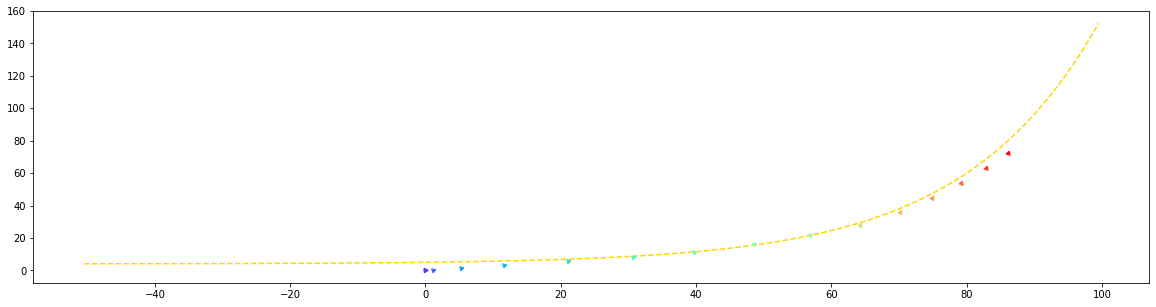

In [24]:
def plot_trajectory(states, road, verbose=False):

    plt.figure(figsize=(20, 5))
    plt.plot(*zip(*road), color='gold', linestyle='--')

    road = np.array(road)

    colors = cm.rainbow(np.linspace(0, 1, len(states)))
    for i, state in enumerate(states):
        x, y, velocity, heading = state
        heading = heading % 360 
        if verbose:
            centerLineDist, _ = shortestDistanceToPolyline(np.array([x, y]), road)
            print(f"x: {x}, y: {y}, velocity: {velocity}, heading: {heading}")
            print(f"centerline error: {centerLineDist}")
        plt.plot(x, y, marker=(3, 0, heading - 90), markersize=5, color=colors[i])
    print('\n' * 2)
    plt.show()


def getUpdatedStates(initialState, controls, timeStep=1):
    states = [initialState]
    state = np.expand_dims(initialState, axis=-1)
    for i in range(0, len(controls), 2):
        control = np.expand_dims(np.concatenate(([0, 0], controls[i:i+2])), axis=-1)
        state = stateUpdateEqn(state, control, timeStep)
        states.append(np.squeeze(state, axis=-1))
    return states


print_states = getUpdatedStates(state0, result.x, timeStep)
plot_trajectory(print_states, road3, verbose=1)